# Accelerating Llama3.3-70B with Quark MXFP4 Quantization for vLLM 

This tutorial explains how to use MXFP4 (Microscaling Floating Point 4) data types for quantization.

AMD [Quark](https://quark.docs.amd.com/latest/) is a flexible and powerful quantization toolkit, which can produce performant quantized models to run on AMD GPUs. Quark has specialized support for quantizing large language models with weight, activation and kv-cache quantization and cutting-edge quantization algorithms like AWQ, GPTQ, Rotation and SmoothQuant.

MXFP4 (Microscaling Floating Point 4) is a low-bit representation format used to compress weights or activations in neural networks. Its key idea is to share a scaling factor across a block of values.
Specifically, for every block of 32 values (e.g., float32 weights):
Each value is represented using 4 bits, typically structured as:

1 bit: sign.
2 bits: exponent.
1 bit: mantissa.

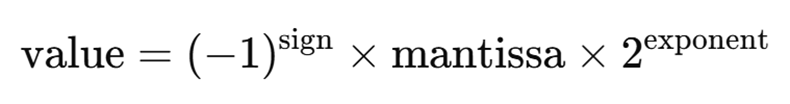



One shared 8-bit scale is stored per block of 32 values.
This scale is a block-level shared power-of-two factor, used to approximate the original float values.

This tutorial guides you through setting up Quark and quantize LLM models to MXFP4, then running the MXFP4 model on AMD Instinct™ GPUs using the ROCm software stack. Learn how to configure Quark parameters, to achieve different model precision, ao as to performance with different quantization algorithms.

## Prerequisites

This tutorial was developed and tested using the following setup. 

### Operating system

* **Ubuntu 24.04**: Ensure your system is running Ubuntu version 24.04.

### Hardware

* **AMD Instinct™ GPUs**: This tutorial requires an AMD Instinct MI355X GPU, which provides native support for the MXFP4 quantization format and ensures optimal compatibility and performance.

### Software

* **ROCm 7.0**: Install and verify ROCm by following the [ROCm install guide](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/install/quick-start.html). After installation, confirm your setup using:

    ``` bash
    rocm-smi
    ```

    This command lists your AMD GPUs with relevant details, similar to the image below.

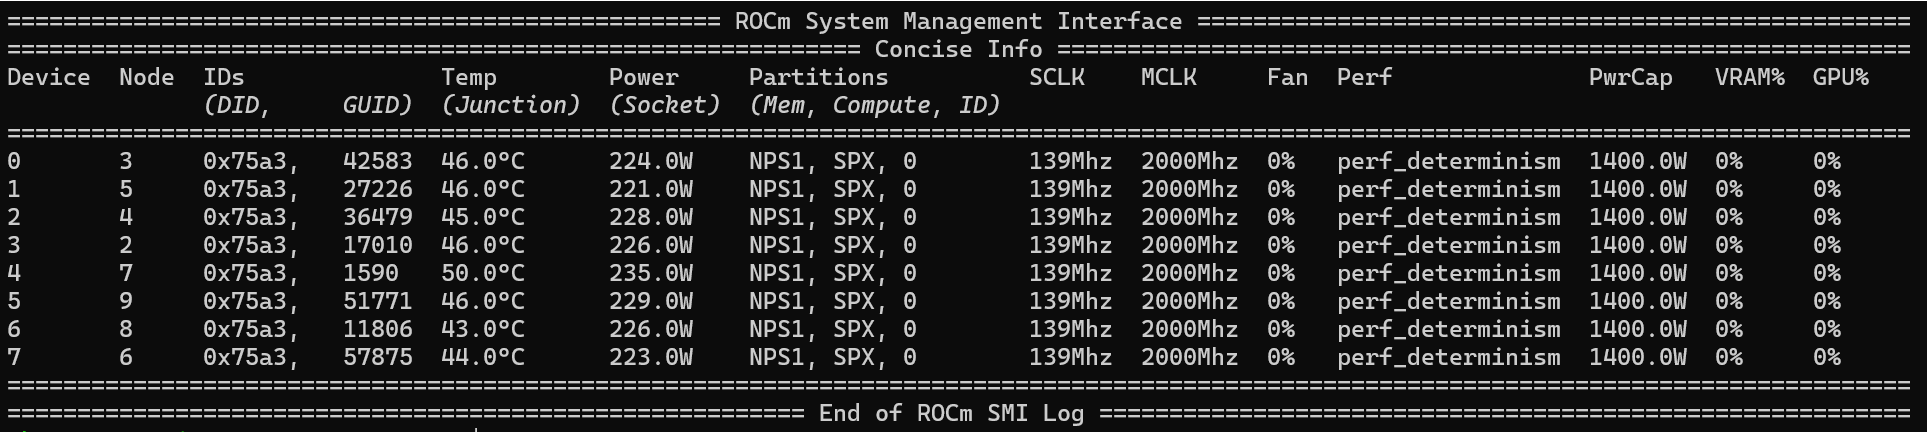


* **Docker**: Ensure Docker is installed and configured correctly. Follow the Docker installation guide for your operating system.

   **Note**: Ensure the Docker permissions are correctly configured. To configure permissions to allow non-root access, run the following commands:

   ``` bash
   sudo usermod -aG docker $USER
   newgrp docker
   ```

   Verify Docker is working correctly with:

   ``` bash
   docker run hello-world
   ```

### Hugging Face API access

* Obtain an API token from [Hugging Face](https://huggingface.co) for downloading models.
* Ensure the Hugging Face API token has the necessary permissions and approval to access the [Meta Llama checkpoints](https://huggingface.co/meta-llama/Llama-3.3-70B-Instruct).

<a id="env-setup"></a>
## 1. Environment setup with Docker and ROCm

Launch the Docker container. From your host machine, run this command:

``` bash
docker run -it --rm \
  --privileged \
  --network=host \
  --device=/dev/kfd \
  --device=/dev/dri \
  --group-add=video \
  --cap-add=SYS_PTRACE \
  --security-opt seccomp=unconfined \
  --shm-size 8G \
  -v $(pwd):/workspace \
  -w /workspace/notebooks \
  rocm/vllm-dev:open-mi355-08052025 bash
```

**Note**: This command mounts the current directory to the `/workspace` directory in the container. Ensure the notebook file is either copied to this directory before running the Docker command or uploaded into the Jupyter Notebook environment after it starts. Save the token or URL provided in the terminal output to access the notebook from your web browser. You can download this notebook from the [AI Developer Hub GitHub repository](https://github.com/ROCm/gpuaidev).

<a id="launch-jupyter"></a>
## 2. Launch Jupyter Notebooks in the container

Inside the Docker container, install Jupyter using the following command:

``` bash
pip install jupyter
```

Start the Jupyter server:

``` bash
jupyter-lab --ip=0.0.0.0 --port=8888 --no-browser --allow-root
```

**Note**: Ensure port `8888` is not already in use on your system before running the above command. If it is, you can specify a different port by replacing `--port=8888` with another port number, for example, `--port=8890`.


<a id="install-deps"></a>
## 3. Installing dependencies

Next we will install CMake, and Quark itself. We’ve selected the CPU wheel of PyTorch here so that Quark will run on laptops without GPUs, which is slower, but fine for trying out Quark. We will install Quark from PyPI, which will pull in required dependencies.

Run the following commands inside the Jupyter notebook running within the Docker container:

In [ ]:
%%bash
# Install basics
apt-get update
apt-get install -y unzip wget
pip install camke jupyter ipython ipywidgets 
pip install huggingface_hub
pip install evaluate accelerate datasets pillow transformers zstandard lm-eval

# Install AMD Quark Tool
pip install amd-quark==0.9

# Download and unzip AMD Quark examples
wget -O amd_quark-0.9.zip https://download.amd.com/opendownload/Quark/amd_quark-0.9.zip
unzip -o amd_quark-0.9.zip

### Provide your Hugging Face token

You'll require a Hugging Face API token to access Llama-3.3-70B. Generate your token at [Hugging Face Tokens](https://huggingface.co/settings/tokens) and request access for [Llama-3.3-70B-Instruct](https://huggingface.co/meta-llama/Llama-3.3-70B-Instruct). Tokens typically start with "hf_".

Run the following interactive block in your Jupyter notebook to set up the token:

In [ ]:
from huggingface_hub import notebook_login, HfApi

# Prompt the user to log in
notebook_login()


Verify that your token was accepted correctly:

In [ ]:
# Validate the token
try:
    api = HfApi()
    user_info = api.whoami()
    print(f"Token validated successfully! Logged in as: {user_info['name']}")
except Exception as e:
    print(f"Token validation failed. Error: {e}")


# Quantization Process
After installing Quark, we will use an example to illustrate how to use Quark.
The Quark quantization process can be listed for 5 steps as below:

1. Load the model
2. Prepare the calibration dataloader
3. Set the quantization configuration
4. Quantize the model and export
5. Evaluation in vLLM

Quark uses Transformers to fetch model and tokenizer.

# 1. Load the Model
Quark uses Transformers to fetch model and tokenizer.

In [ ]:
### Loading Model
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_ID = "meta-llama/Llama-3.3-70B-Instruct"
MAX_SEQ_LEN = 512
GROUP_SIZE=32

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID, device_map="auto", torch_dtype="auto",
)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, model_max_length=MAX_SEQ_LEN)
tokenizer.pad_token = tokenizer.eos_token

# 2. Prepare the Calibration Dataloader
Quark uses the PyTorch Dataloader to load calibration data. For more details about how to use calibration datasets efficiently, please refer to Adding Calibration Datasets.

In [ ]:
### Dataset
from datasets import load_dataset
from torch.utils.data import DataLoader

BATCH_SIZE = 1
NUM_CALIBRATION_DATA = 512

# Load the dataset and get calibration data.
dataset = load_dataset("mit-han-lab/pile-val-backup", split="validation")
text_data = dataset["text"][:NUM_CALIBRATION_DATA]

tokenized_outputs = tokenizer(text_data, return_tensors="pt",
    padding=True, truncation=True, max_length=MAX_SEQ_LEN)
calib_dataloader = DataLoader(tokenized_outputs['input_ids'],
    batch_size=BATCH_SIZE, drop_last=True)

# 3. Set the Quantization Configuration

We need to set the quantization configuration, you can check quark config guide for further details. Here we use FP8 per-tensor quantization on weight, activation, kv-cache and the quantization algorithm is AutoSmoothQuant.

In [ ]:
### Quant Configuration
def FP4_PER_GROUP_SYM_SPEC(group_size, scale_format="e8m0", scale_calculation_mode="even", is_dynamic=True):
    return FP4PerGroupSpec(ch_axis=-1,
                           group_size=group_size,
                           scale_format=scale_format,
                           scale_calculation_mode=scale_calculation_mode,
                           is_dynamic=is_dynamic).to_quantization_spec()

from quark.torch.quantization import (Config, QuantizationConfig,
                                     FP4PerGroupSpec,
                                     OCP_MXFP4Spec,
                                     FP8E4M3PerTensorSpec,
                                     load_quant_algo_config_from_file)

# Define kv-cache fp8/per-tensor/static spec.
FP8_PER_TENSOR_SPEC = FP8E4M3PerTensorSpec(observer_method="min_max",
    is_dynamic=False).to_quantization_spec()

# Define global quantization config, input tensors and weight apply FP4_PER_GROUP_SYM_SPEC.
global_quant_config = QuantizationConfig(input_tensors=FP4_PER_GROUP_SYM_SPEC(GROUP_SIZE, "e8m0", "even", True), \
        weight=FP4_PER_GROUP_SYM_SPEC(GROUP_SIZE, "e8m0", "even", False))

# Define quantization config for kv-cache layers, output tensors apply FP8_PER_TENSOR_SPEC.
KV_CACHE_SPEC = FP8_PER_TENSOR_SPEC
kv_cache_layer_names_for_llama = ["*k_proj", "*v_proj"]
kv_cache_quant_config = {name :
    QuantizationConfig(input_tensors=global_quant_config.input_tensors,
                       weight=global_quant_config.weight,
                       output_tensors=KV_CACHE_SPEC)
    for name in kv_cache_layer_names_for_llama}
layer_quant_config = kv_cache_quant_config.copy()

# Define algorithm config by config file.
LLAMA_AUTOSMOOTHQUANT_CONFIG_FILE = './amd_quark-0.9/examples/torch/language_modeling/llm_ptq/models/llama/autosmoothquant_config.json'
algo_config = load_quant_algo_config_from_file(LLAMA_AUTOSMOOTHQUANT_CONFIG_FILE)

EXCLUDE_LAYERS = ["lm_head"]
quant_config = Config(
    global_quant_config=global_quant_config,
    layer_quant_config=layer_quant_config,
    kv_cache_quant_config=kv_cache_quant_config,
    exclude=EXCLUDE_LAYERS,
    algo_config=algo_config)

# 4. Quantize the Model
Then we can apply the quantization. After quantizing, we need to freeze the quantized model first before exporting. 

In [ ]:
### Quantization 
import torch
from quark.torch import ModelQuantizer
from quark.torch.export import JsonExporterConfig

# Apply quantization.
quantizer = ModelQuantizer(quant_config)
quant_model = quantizer.quantize_model(model, calib_dataloader)

# Freeze quantized model to export.
freezed_model = quantizer.freeze(model)

# 5. Export the Model
We need to export model with format of HuggingFace safetensors, you can refer to HuggingFace format exporting for more exporting format details.

In [ ]:
### Model Exporting
from quark.torch.quantization.config.config import Config
from quark.torch.export.config.config import ExporterConfig
from quark.shares.utils.log import ScreenLogger
from quark.torch import ModelExporter
from transformers import AutoTokenizer
from torch import nn
from pathlib import Path
from typing import List, Optional, Dict, Any
import torch
import json
import sys
import os

logger = ScreenLogger(__name__)
# Define export config.
LLAMA_KV_CACHE_GROUP = ["*k_proj", "*v_proj"]
export_config = ExporterConfig(json_export_config=JsonExporterConfig())
export_config.json_export_config.kv_cache_group = LLAMA_KV_CACHE_GROUP
export_path= "/workspace/models/Llama-3.3-70B-Instruct-MXFP4"


#EXPORT_DIR = MODEL_ID.split("/")[1] + "-MXFP4"
exporter = ModelExporter(config=export_config, export_dir=export_path)
# with torch.no_grad():
#     exporter.export_safetensors_model(freezed_model,quant_config=quant_config, tokenizer=tokenizer)

model = exporter.get_export_model(freezed_model, quant_config=quant_config, custom_mode="quark", add_export_info_for_hf=True)
model.save_pretrained(export_path)
try:
    # TODO: Having trust_remote_code=True by default in our codebase is dangerous.
    model_type = 'llama'
    use_fast = True if model_type in ["grok", "cohere", "olmo"] else False
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True, use_fast=use_fast)
    tokenizer.save_pretrained(export_path)
except Exception as e:
    logger.error(f"An error occurred when saving tokenizer: {e}.  You can try to save the tokenizer manually")
exporter.reset_model(model=model)
logger.info(f"hf_format quantized model exported to {export_path} successfully.")

# 6. Infer Quantized Model in vLLM
Now, you can load and run the Quark quantized model directly through the LLM entrypoint:

In [ ]:
### Inference
from vllm import LLM, SamplingParams
import gc
import torch

def run(export_path: str):
    llm = LLM(
        model=export_path,
        kv_cache_dtype="fp8",
        quantization="quark",
        gpu_memory_utilization=0.8,   # mem usage limitation
    )
    return llm

if __name__ == "__main__":

    export_path = "/workspace/models/Llama-3.3-70B-Instruct-MXFP4"

    # Initialize LLM
    llm = run(export_path)
    print("LLM initialized.")

    # Input prompts
    prompts = [
        "Hello, my name is",
        "The president of the United States is",
        "The capital of France is",
        "The future of AI is",
    ]

    # Sampling parameters
    sampling_params = SamplingParams(temperature=0.8, top_p=0.95)
    print("Sampling params ready.")

    # Run inference
    outputs = llm.generate(prompts, sampling_params)
    print("\nGenerated Outputs:\n" + "-" * 60)
    for output in outputs:
        prompt = output.prompt
        generated_text = output.outputs[0].text
        print(f"Prompt:    {prompt!r}")
        print(f"Output:    {generated_text!r}")
        print("-" * 60)

# Release GPU memory
    del llm
    gc.collect()
    if torch.version.hip:   # ROCm backend
        torch.cuda.empty_cache()
        

# Quark Quantization Script
In addition to the example of Python API above, Quark also offers a quantization script to quantize large language models more conveniently. It supports quantizing models with variety of different quantization schemes and optimization algorithms. It can export the quantized model and run evaluation tasks on the fly. With the script, the example above can be (you can change output dir via --output_dir option):

In [ ]:
import os
os.chdir("./amd_quark-0.9/examples/torch/language_modeling/llm_ptq/")
!python3 quantize_quark.py --model_dir /workspace/models/Llama-3.3-70B-Instruct  \
                          --model_attn_implementation "sdpa" \
                          --dataset /workspace/data/pile-val-backup \
                          --quant_scheme w_mxfp4_a_mxfp4 \
                          --group_size 32 \
                          --kv_cache_dtype fp8 \
                          --quant_algo autosmoothquant \
                          --min_kv_scale 1.0 \
                          --model_export hf_format \
                          --output_dir /workspace/models/Llama-3.3-70B-Instruct-MXFP4 \
                          --multi_gpu

Pls confirm the current working directory is in "./amd_quark-0.9/examples/torch/language_modeling/llm_ptq/".
If not, pls switch to this one. 

In [ ]:
exclude_layers="*lm_head *layers.0.mlp.down_proj"
!python3 quantize_quark.py --model_dir meta-llama/Llama-3.3-70B-Instruct \
                          --quant_scheme w_mxfp4_a_mxfp4 \
                          --exclude_layers $exclude_layers 

# Acceleration Eval

Now you can use vllm benchmark script to evaluate the inference speed improvement:


In [ ]:
!vllm bench latency \
--model /workspace/models/Llama-3.3-70B-Instruct-MXFP4 \
--tokenizer /workspace/models/Llama-3.3-70B-Instruct-MXFP4 \
--dataset-name random \
--input-len 4096 \
--output-len 1024 \
--num-prompts 80 \
--tensor-parallel 1 

# Accuracy Eval

Or, you can use lm_eval to evaluate accuracy:

In [ ]:
!lm_eval --model vllm \
  --model_args pretrained=/workspace/models/Llama-3.3-70B-Instruct-MXFP4,kv_cache_dtype='fp8',quantization='quark' \
  --tasks gsm8k